## IMPORT PACKAGES 

In [30]:
import nltk
import numpy as np
import csv
#tqdm : 进度条
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as split
#用于在jupyter 显示图像
%matplotlib inline

In [3]:
#无法下载则去www.nltk.org/nltk_data官网下载后放在相应目录下
#官网用chrome可以下载
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joker\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## READ DATA 


In [18]:
#Variables

FILE_PATH = './datasets/training-v1/offenseval-training-v1.tsv'

In [13]:
def str_to_label(text_label):
    label = 0
    if text_label == 'OFF':
        label = 1
    return label

In [20]:
#从tsv文档读数据
#输入数据格式：
#id,tweet,label_a,label_b,label_c
#输出data list [tweet1, tweet2,...]
#输出label list [label1, label2, ...]
def get_training_data(FILE_PATH):
    data = []
    labels = []
    with open(FILE_PATH, encoding='utf-8') as tsvfile:
        reader = csv.reader(tsvfile,delimiter='\t')
        for i,line in enumerate(tqdm(reader,'READING DATA.....')):
            if i is 0:
                #不读第一行（title）
                continue
            label = str_to_label(line[-3])
            data.append(line[1])
            labels.append(label)
    return data, labels
            

In [24]:
all_data, all_labels = get_training_data(FILE_PATH)

READING DATA.....: 13241it [00:00, 212044.47it/s]


In [25]:
print(all_data[:3])
print(all_labels[:3])

['@USER She should ask a few native Americans what their take on this is.', '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL', 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT']
[1, 1, 0]


In [27]:
## 为了评估模型性能，需要labeled test data
## 从数据中分出1/10做validation data, 1/10做test data
## 首先shuffle数据
shuffled_data, shuffled_labels = shuffle(all_data, all_labels, random_state=0)

In [28]:
print(shuffled_data[:3])
print(shuffled_labels[:3])

['@USER Good! #Antifa is violent fascism.', "@USER It has been being de-created slowly and stealthily since the CONservatives came to power... Hunt's done a sterling job.", "* Christian Kabasele reveals the secrets behind Watford's perfect start to the Premier League season : Beans are banned at Watford's training ground so Christian Kabasele spills the avocado and quinoa. He is is intelligent.. . URL URL"]
[0, 0, 0]


In [82]:
#split train and test
train_data,test_data,train_labels,test_labels = split(shuffled_data,\
                                                     shuffled_labels,\
                                                     test_size=0.1)

## Data Statics

In [78]:
def get_statics(data,label,datatype,tokenized = False):
    length = len(data)
    off_d = sum(label)
    off = round(off_d/length,4)
    wc = 0
    vocab = set()
    
    for t in data:
        ## to be modified for efficiency
        if tokenized:
            t_list = t
        else:
            t_list = t.split(' ')
        wc += len(t_list)
        for w in t_list:
            vocab.add(w)
    a_wc = round(wc/length,2)
    
    
    print('--------'+'For %s set'%(datatype)+'-------')
    print('Length: %d'%(length))
    print('with offensive tweets %d,%.4f'%(off_d,off))
    print('average length: %.2f'%(a_wc))
    print('vocab size: %d'%(len(vocab)))
    print()

In [83]:
get_statics(train_data,train_labels,'training')
get_statics(test_data,test_labels,'testing')


--------For training set-------
Length: 11916
with offensive tweets 3965,0.3327
average length: 22.73
vocab size: 36605

--------For testing set-------
Length: 1324
with offensive tweets 435,0.3285
average length: 22.62
vocab size: 7644



## Pre-processing

In [46]:
##接下来对数据做预处理
##问题：
##1. 不能完全凭空格做好分词，有相连的标点、专有名词等的干扰
##2. 口语化，不规范用词
##3. 待补充

In [90]:
train_data[:3]

['@USER she is',
 '@USER @USER @USER @USER @USER Thank you mama cookie she is my long distance cousin. She will treat you well.',
 '@USER @USER @USER @USER @USER @USER They can’t. His a sheep. Just follow along with fake news and put everyone who can think for themselves as KKK. Antifa wannabes']

### 分词

In [86]:
## 1. 分词
def tokenize(data):
    from nltk import word_tokenize
    seg_data = []
    for t in tqdm(data,'Tokenization...'):
        seg_data.append(word_tokenize(t.lower()))
    return seg_data

In [87]:
seg_train_data = tokenize(train_data)

Tokenization...: 100%|█████████████████████████████████████████████████████████| 11916/11916 [00:07<00:00, 1666.35it/s]


In [95]:
seg_test_data = tokenize(test_data)

Tokenization...: 100%|███████████████████████████████████████████████████████████| 1324/1324 [00:00<00:00, 2148.55it/s]


In [96]:
get_statics(seg_train_data, train_labels,'tokenized training data',True)

get_statics(seg_test_data, test_labels,'tokenized test data',True)

--------For tokenized training data set-------
Length: 11916
with offensive tweets 3965,0.3327
average length: 28.34
vocab size: 20667

--------For tokenized test data set-------
Length: 1324
with offensive tweets 435,0.3285
average length: 28.45
vocab size: 5329



In [100]:
seg_train_data[0]

['@', 'user', 'she', 'is']

### 去停用词

In [145]:
def remove_sw(data):
    from nltk.corpus import stopwords
    import re
    stop = set(stopwords.words('english'))
    noise = ['user','URL','amp'] #除去@User等自定义的停用词
    removed_sw = []
    for t in tqdm((data),'Removing Stopwords.....'):
        removed_sw.append([w for w in t if w not in stop and \
                           not re.match(r"[^a-zA-Z\d\s]+", w) and\
                           w not in noise])
    return removed_sw

In [146]:
clean_train_data = remove_sw(seg_train_data)
get_statics(clean_train_data,train_labels,'cleaned training data',True)

Removing Stopwords.....: 100%|████████████████████████████████████████████████| 11916/11916 [00:00<00:00, 38137.95it/s]


--------For cleaned training data set-------
Length: 11916
with offensive tweets 3965,0.3327
average length: 10.47
vocab size: 19303



In [111]:
clean_train_data[:3]

[[],
 ['thank', 'mama', 'cookie', 'long', 'distance', 'cousin', 'treat', 'well'],
 ['sheep',
  'follow',
  'along',
  'fake',
  'news',
  'put',
  'everyone',
  'think',
  'kkk',
  'antifa',
  'wannabes']]

In [134]:
#删掉为空的句子
f_clean_train_data =[]
f_clean_train_labels = []
for i in range(len(clean_train_data)):
    t = clean_train_data[i]
    l = train_labels[i]
    if len(t) >= 1:
        f_clean_train_data.append(t)
        f_clean_train_labels.append(l)
#f_clean_train_data = [t for t in clean_train_data if len(t)>1]
get_statics(f_clean_train_data,f_clean_train_labels,'cleaned training data',True)

--------For cleaned training data set-------
Length: 11859
with offensive tweets 3961,0.3340
average length: 10.57
vocab size: 19304



In [135]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
def get_pos(word):
    tag = pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def lemmatize(data):

    
    wnl = WordNetLemmatizer()
    lemma_data = []
    for t in tqdm(data,'Lemmatization...'):
        this_lemma = [wnl.lemmatize(w, get_pos(w)) for w in t]
        lemma_data.append(this_lemma)
    return lemma_data
    

In [136]:
lemma_train_data = lemmatize(f_clean_train_data)

Lemmatization...: 100%|█████████████████████████████████████████████████████████| 11859/11859 [00:56<00:00, 209.17it/s]


In [122]:
get_statics(lemma_train_data,train_labels,'lemmad data', True)

--------For lemmad data set-------
Length: 11375
with offensive tweets 3965,0.3486
average length: 10.98
vocab size: 16082



In [114]:
lemma_train_data[:3]

[[],
 ['thank', 'mama', 'cookie', 'long', 'distance', 'cousin', 'treat', 'well'],
 ['sheep',
  'follow',
  'along',
  'fake',
  'news',
  'put',
  'everyone',
  'think',
  'kkk',
  'antifa',
  'wannabe']]

In [138]:
    def word_cloud(data,name,labels=None,filter=None):
        if not isinstance(data[0],list):
            raise Exception('Data must be tokenized before using word cloud.')
        import matplotlib.pyplot as plt
        from wordcloud import WordCloud
        filters = ['NON','OFF']
        if not filter:
            plot_data = [w for i,tweet in enumerate(data) for w in tweet]
        else:
            if not labels:
                raise Exception('Labels must be provided for filtering text.')
            filter = filters.index(filter)
            plot_data = [w for i,tweet in enumerate(data) for w in tweet if labels[i]==filter]
        all_words = ' '.join(plot_data)
        wordcloud = WordCloud(width=800, height=500,background_color="white", random_state=21, max_font_size=110).generate(all_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.savefig(name+'wordcloud.png')
        plt.show()

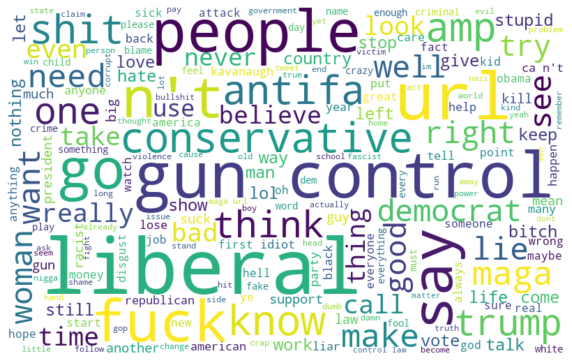

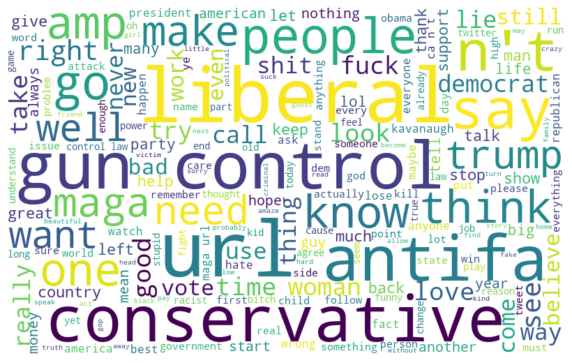

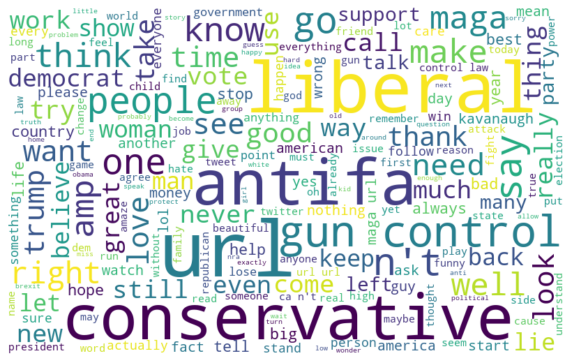

In [141]:
word_cloud(lemma_train_data,name='off',labels=f_clean_train_labels,filter='OFF')
word_cloud(lemma_train_data,name='overall')
word_cloud(lemma_train_data,name='nonoff',labels=f_clean_train_labels,filter='NON')

In [ ]:
for t in seg_train_data:
    if 'url' in t:
        print(t)

['@', 'user', '@', 'user', '@', 'user', 'cnn', '&', 'amp', ';', 'others', 'involved', 'in', 'conspiracy', 'theories', "''", '&', 'amp', ';', 'propaganda', 'while', 'they', 'protect', '(', 'antifa', '?', ')', '.', 'so', 'i', 'guess', 'the', '2013', 'bill', '&', 'amp', ';', '2016', 'bills', 'for', 'propaganda', 'does', 'protect', '``', 'state', 'media', "''", '?', '?', '?', 'url']
['@', 'user', '@', 'user', 'what', 'a', 'baby', '!', 'url']
['@', 'user', 'certainly', 'does', 'url']
['@', 'user', '@', 'user', 'eric', 'holder', 'is', 'a', 'filthy', 'maggot', '.', 'url']
['@', 'user', '@', 'user', '@', 'user', '@', 'user', '@', 'user', '5.', 'creating', 'racial', 'tension', "''", '.', 'usa', 'racial', 'issues', 'start', 'before', '1776.', 'these', 'latest', 'ones', 'are', 'fueled', 'by', ',', 'among', 'others', ',', 'nra', '&', 'amp', ';', 'congress', 'refusing', 'to', 'fully', 'resource', 'education', '&', 'amp', ';', 'police', 'training', '.', 'url', 'url', 'url', 'url']
['this', 'day', 'i